# Implementation of conversion reaction model

The model, which will be implemented using the SBML format and PEtab, is from the thesis of Lukas Spögler. For theoretical questions one needs to search there.
The SBML file was build with COPASI by defining two sepcies $A$ and $B$ together with the evolution of their concentration in terms of ODEs. 
First we import the SBML file and all necessaryy modules.

In [2]:

import libsbml
import importlib
import os
import sys

import amici
import amici.plotting
import numpy as np

import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize

import petab
import petab_select

#sbml file we want to use
sbml_file = "copasi_with_ode_cleaned.xml"
# model name
model_name = "conversion_reaction"
#output directory, to which generated model code is written
model_output_dir = "tmp/"+model_name

### Compile and load AMICI model

In [4]:
# model compilation
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name, model_output_dir, verbose=False)

# loading the model module
model_module = amici.import_model_module(model_name, model_output_dir)
model = model_module.getModel()
solver = model.getSolver()


### Running simple simulation

In [6]:
# set parameter values
model.setParameterByName("k1", 0.2)
model.setParameterByName("k2", 0.1)
model.setParameterByName("k3", 0)

#set timepoints
model.setTimepoints(np.linspace(0, 60, 13))

# run simulation
rdata = amici.runAmiciSimulation(model, solver)

### Investigate and visualize results

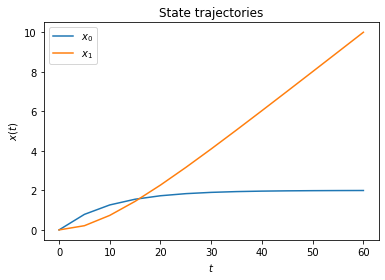

In [9]:
#rdata.x

#model.getStateNames()

amici.plotting.plotStateTrajectories(rdata)

### Simulation with noise

Next we specify an observable consisting of the concentration of the second species and add normal distributed measurement noise to get artifical experimental data.

In [13]:
# new model with noise
noise_model_name = "noisy_conversion_reaction"
noise_model_output_dir = "tmp/"+ noise_model_name

# define observables
observables = {'observable_Bwithnoise': {'name': '', 'formula': 'B'}}

# define noise as parameter
sigma = {'observable_Bwithnoise': 'observable_Bwithnoise_sigma'}

# generating the module
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(noise_model_name, noise_model_output_dir, verbose=False)

# loading the model module
noise_model_module = amici.import_model_module(noise_model_name, noise_model_output_dir)
noise_model = noise_model_module.getModel()
noise_solver = noise_model.getSolver()

print("Model name:", noise_model.getName())
print("Model parameters:", noise_model.getParameterIds())
print("Model outputs:   ", noise_model.getObservableIds())
print("Model states:    ", noise_model.getStateIds())

Model name: noisy_conversion_reaction
Model parameters: ('k1', 'k2', 'k3')
Model outputs:    ('yA', 'yB', 'yModelValue_0', 'yModelValue_2', 'yModelValue_1', 'yCell')
Model states:     ('A', 'B')


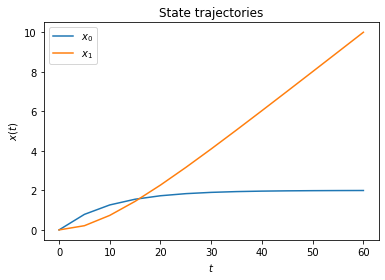

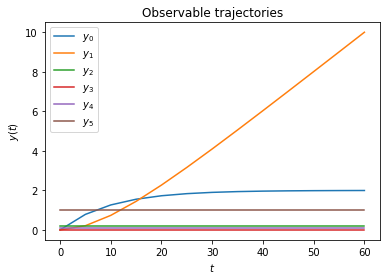

In [17]:
noise_model.setTimepoints(np.linspace(0, 60, 13))

noise_model.setParameterByName("k1", 0.2)
noise_model.setParameterByName("k2", 0.1)
noise_model.setParameterByName("k3", 0)

# Run simulation using default model parameters and solver options
noise_rdata = amici.runAmiciSimulation(noise_model, noise_solver)


amici.plotting.plotStateTrajectories(noise_rdata)
amici.plotting.plotObservableTrajectories(noise_rdata)

edata = amici.ExpData(rdata, 0.15, 0.0)